In [278]:
import dynamiqs as dq
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from scipy.stats import qmc
import pandas as pd
import scipy as sp

In [242]:
# class allows sampling from a wigner function of a given state
class StateSampler:
    def __init__(self, state=None, data=None, noise=False, state_name=None):
        self.state_name = state_name
        self.state = state
        self.X, self.Y, self.W = dq.wigner(state) if state is not None else data
        if data:
            self.state = data
        self.noise = noise

    def get_sample(self,x):
        ndim = len(np.array(x).shape)
        if ndim==1:
            val = np.float32(sampler.W[np.argmin(np.abs(self.X-x[0]))][np.argmin(np.abs(self.Y-x[1]))])
            return val + self.noise * np.random.rand() if self.noise else val
        elif ndim==2:
            return np.array([self.get_sample(y) for y in x])
        print(f"NOPE ndim={ndim}")
        return        

In [274]:
def ketbra(n,m,dim=5):
    """ returns the basis ket-bras of hermitian density matrices"""
    if n == m:
        return dq.fock(dim,n)@dq.fock(dim,m).dag()
    elif n < m:
        return (dq.fock(dim,n)@dq.fock(dim,m).dag() + dq.fock(dim,m)@dq.fock(dim,n).dag())/np.sqrt(2)
    else: # n > m
        return -1j*(dq.fock(dim,n)@dq.fock(dim,m).dag() - dq.fock(dim,m)@dq.fock(dim,n).dag())/np.sqrt(2)

def get_dm(rho):
    """returns density matrix from vector"""
    dim = round(np.sqrt(len(rho)))
    return dq.asqarray(np.sum([rho[n+m*dim] * ketbra(n,m,dim) for m in range(dim) for n in range(dim)], axis=0))

def get_vec(rho_dm):
    """calculates vector from DM"""
    dim = len(rho_dm)
    return [np.trace(ketbra(n,m,dim)@rho_dm) for m in range(dim) for n in range(dim)]

class Kerneliser:
    def __init__(self, dim=5):
        self.dim = dim
        self.X, self.Y, _ = dq.wigner(ketbra(0,0, dim=dim))
        self.wigners = [[dq.wigner(ketbra(n,m,dim=dim))[2] for m in range(dim)] for n in range(dim)]

    def get_kernel(self, x):
        """evaluate the basis-wigner fuctions at a given point x = (x,p)"""
        ndim = len(np.array(x).shape)
        if ndim==1:
            idxs = [np.argmin(np.abs(self.X-x[0])), np.argmin(np.abs(self.Y-x[1]))]
            return np.array([self.wigners[n][m][idxs[0]][idxs[1]] for m in range(self.dim) for n in range(self.dim)])
        elif ndim==2:
            return np.array([self.get_kernel(y) for y in x])
        print(f"NOPE ndim={ndim}")
        return

def rel_entropy(pred, ground_truth):
    return np.trace(ground_truth@(sp.linalg.logm(pred, disp=False)[0] - sp.linalg.logm(ground_truth, disp=False)[0]))

In [295]:
# define parameters
dim = 10
kerneliser = Kerneliser(dim)

In [296]:
# define some states to test on
fockstates = [dq.fock(dim, i) for i in range(3)] 
coherentstates = [dq.coherent(dim, np.exp(2j *np.pi/3 * i)) for i in range(3)]

def ncat(n, alpha, dim): # function that returns an n-Cat state with a given phase alpha
    cat = dq.coherent(dim, alpha)
    for k in range(1, n):
        cat += dq.coherent(dim, jnp.exp(2j*jnp.pi*k/n)*alpha)
    return cat/dq.norm(cat)
catstates = [ncat(i, np.exp(1j *np.pi/2), dim) for i in range(1,4)]

In [297]:
# data = pd.read_pickle("./../data/synthetic/quantum_state_4.pickle")
# if isinstance(data, tuple):
#     sampler = StateSampler(data=data)
# else:
#     sampler = StateSampler(state=data)

sampler = StateSampler(state=(dq.coherent(dim,2) - dq.coherent(dim,-2))/np.sqrt(2), noise=0.1, state_name="Cat")

In [387]:
sampler = StateSampler(state=coherentstates[2], noise=0, state_name="coh")

In [395]:
n_points = 100

x_training = np.random.normal(loc=0, scale=1, size=n_points * 2).reshape(-1, 2)
# x_training = 2*(2*qmc.Sobol(d=2, scramble=True).random_base2(m=int(np.log2(n_points)))-1) # more uniform sampling

y_training = sampler.get_sample(x_training)
phi_training = kerneliser.get_kernel(x_training)

In [396]:
reg = LinearRegression().fit(phi_training, y_training)
dm_out = get_dm(reg.coef_)
dm_out /= dq.norm(dm_out)

dm_gt = sampler.state/dq.norm(sampler.state)

dq.norm(dm_out)

Array(1., dtype=float32)

In [397]:
fid = float(dq.fidelity(dm_gt, dm_out))
rel_entr = float(np.real(rel_entropy(dm_out.to_numpy(), dm_gt.todm().to_numpy())))
fid, rel_entr

(1.2858551740646362, 0.23204354838253297)

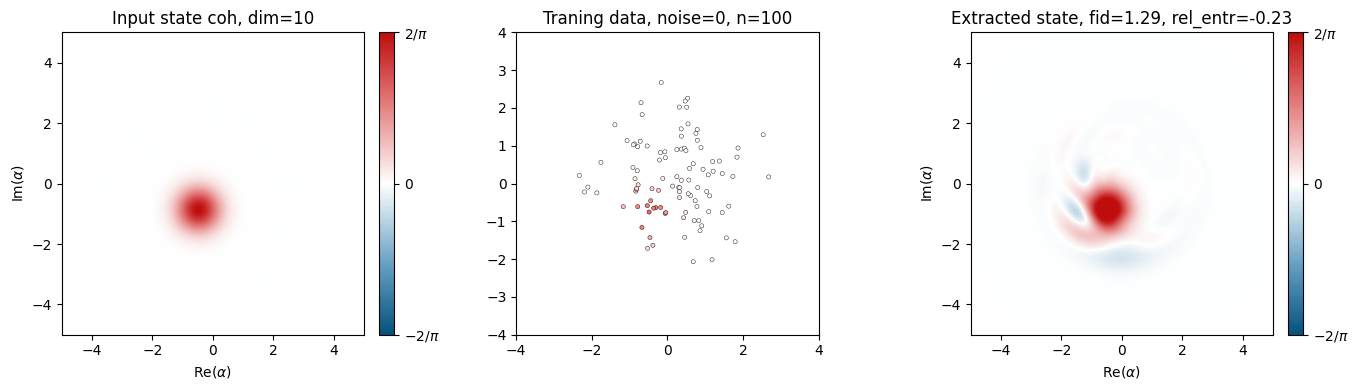

In [398]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
dq.plot.wigner(sampler.state, ax=axes[0])
dq.plot.wigner(dm_out, ax=axes[2])
axes[0].set_title(f"Input state {sampler.state_name}, dim={sampler.state.dims[0]}")
axes[1].scatter(*x_training.T, marker='.', edgecolors='k', lw=0.3, c=y_training, cmap='bwr', vmax=1, vmin=-1)
axes[1].set_xlim([-4, 4])
axes[1].set_ylim([-4, 4])
axes[1].set_aspect(1)
axes[1].set_title(f"Traning data, noise={sampler.noise}, n={n_points}")
axes[2].set_title(f"Extracted state, fid={fid:.2f}, rel_entr={-rel_entr:.2f}")
plt.tight_layout()
plt.savefig(f"{sampler.state_name}_{sampler.state.dims[0]}_{sampler.noise}_{int(100*fid)}.pdf")
plt.show()

In [399]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
# reg.set_params(alpha_init=init[0], lambda_init=init[1])
reg.fit(phi_training, y_training)

BayesianRidge(compute_score=True, tol=1e-06)

In [400]:
phi = np.identity(dim**2)
y, std = reg.predict(phi, return_std=True)

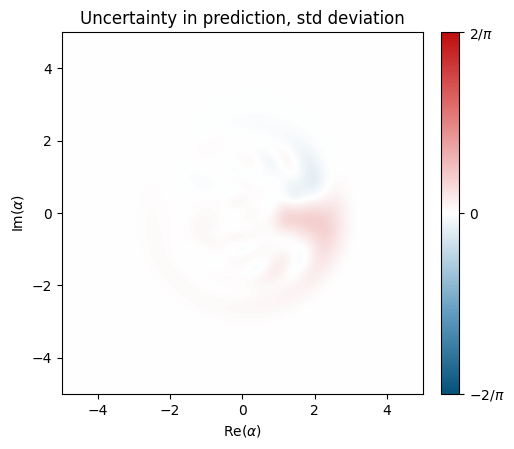

In [401]:
dq.plot.wigner(get_dm(std))
plt.title("Uncertainty in prediction, std deviation")
plt.savefig(f"{sampler.state_name}_{sampler.state.dims[0]}_{sampler.noise}_{int(100*fid)}_uncertainty.pdf")